# Welcome!

This notebook is intended to serve as a gentle introduction to topic modeling in Gensim. It's also essentially a replacement for the slides that I might normally use to introduce these topics, so there should be enough information here for you to follow along and learn (almost) everything you need to know!

## Acknowledgments

Thanks to Max Noichl for the code that loads JSTOR Constellate data.

# What's Topic Modeling?

It's important to be clear about what topic modeling is and isn't, and what it can and can't do. To that end, I'll introduce how topic modeling works – but backwards: I want to start with the more formal/modeling details, and only later, _after_ you see what the algorithm is "really" doing, talk about how we normally interpret the output of algorithms like these.

## A Document Construction Algorithm

Perhaps the easiest way to think about what topic modeling is doing is to think of it as proposing **a mathematical model for the way that documents are written,** and then **inferring the values for the parameters in that model from your documents.** That's a mouthful, so let me show you what I mean.

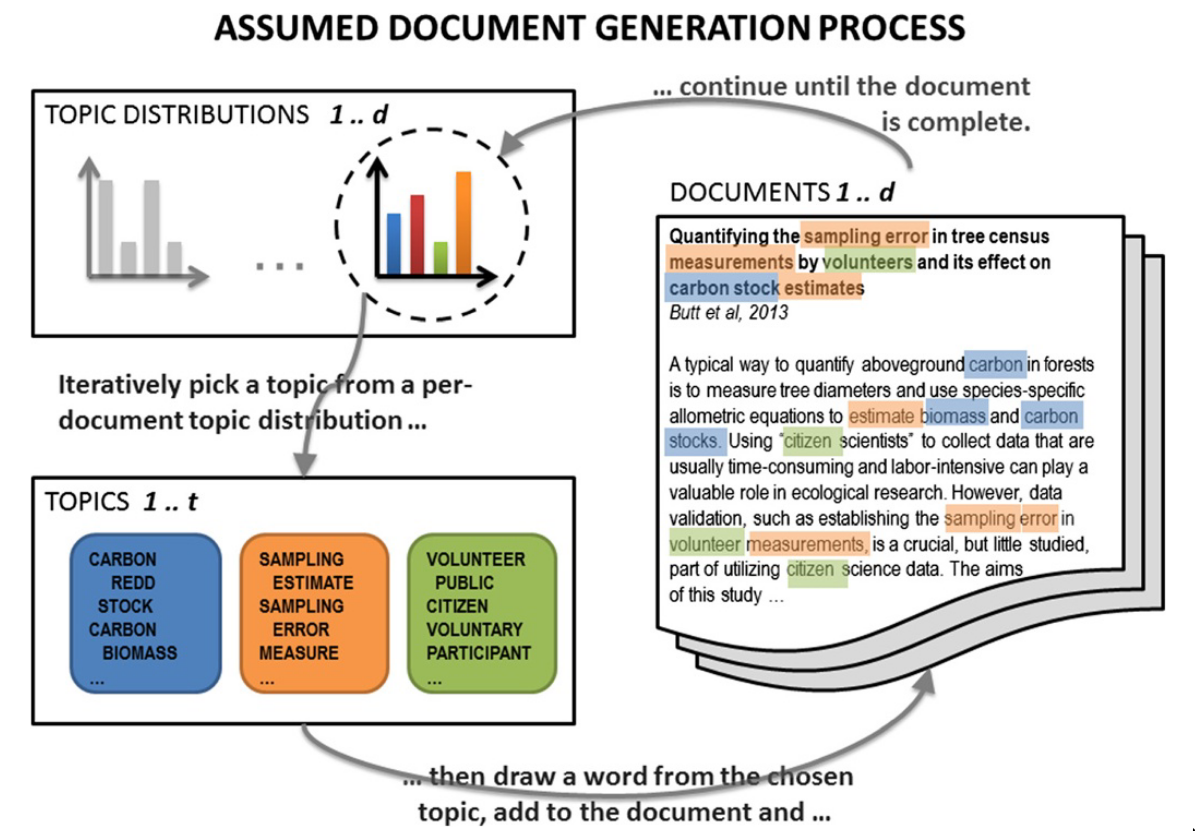



Here's the mathematical model. First, we assume the existence of $k$ topics in the corpus. That's a parameter that you have to provide as the user – we'll talk (a lot) more in a while about how you come up with it. Then, we imagine that each document is generated as follows:

1. Choose what topic the next word will come from, by sampling from a probability distribution for each document over topics, $\Pr(t \mid d)$. Call that topic $t$.
2. Choose what the word will be, by sampling from a probability distribution for each topic over words, $\Pr(w \mid t)$.
3. Repeat until you arrive at the number of words for the document.

Now, _obviously_ this is not how documents are actually written. But the idea is simple enough: we have reduced all the complexity of the creation of text down to the definition of a finite number of probability distributions:

- $\Pr(t \mid d)$ --- the probability of each topic within each document (there will be $D$ of these, the number of documents in the corpus)
- $\Pr(w \mid t)$ --- the probability of each word appearing within each topic (there will be $k$ of these, the number of topics that we chose above)

What the process of topic modeling does, then, is the following: it _assumes_ that your documents were written by this process, and then it _estimates_ (without your needing to "train" the algorithm in any way, other than setting the value $k$) what good values for those probability distributions might be. I'll come back to how these estimations work in just a second, but for now, this brief introduction already indicates a few important features of topic modeling that we should pause to underline.

A topic **just is a probability distribution over every word in the corpus.** That's it. Nothing less, nothing more. We'll be seeing lots of ways to visualize, understand, and interpret those topics. But it's crucial to keep in mind that *all of that will just be interpretation or fancy graphics* on top of the underlying probability distributions.

And secondly, topic models **function over words, not over more complex units of syntax.** There is no sense in which the topic model "understands" the document. This is a compelling illusion, as you'll soon see, and one that's sometimes hard to dispel! Topics will _seem_ really smart, and they can teach us lots of interesting things about what's happening in a corpus. But keeping the real mechanics in the back of your mind whenever you work with a topic model will help you avoid giving them too much credit.

# How It Works

I'm not _actually_ going to explain the details of how the machine decides optimal values for these probability distributions. If you're interested, here's some important terms you can use to start learning the relevant theory. The formal name for that model above – the one that is assumed to generate documents – is [Latent Dirichlet allocation, or LDA.](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) (Lots of things surrounding topic modeling have LDA in their name; now you'll know why.)

There are lots of different ways in which you can approximate solutions to LDA (i.e., figure out what those $D + k$ different probability distributions are). Probably the most common one is known as [Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling), and it's implemented by a number of popular topic modeling packages, such as [MALLET](http://mallet.cs.umass.edu/index.php). The Python-based system that we'll use for topic modeling, known as [Gensim](https://radimrehurek.com/gensim/index.html), implements a slightly more complicated algorithm for LDA estimation, [described in this paper](https://papers.neurips.cc/paper/2010/file/71f6278d140af599e06ad9bf1ba03cb0-Paper.pdf).

# Why though?

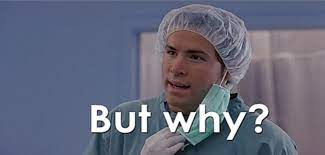

If you've been following along so far, you're probably thinking: great, but why would anybody actually *do* this? What's the point of approximating the process of writing documents by a method that takes absolutely no semantics into account and assumes that text is just about randomly, probabilistically sampling words?

The answer is, basically, empirical. So let's see a fancy example of what kind of thing topic modeling can do, [which comes from this excellent paper](https://www.journals.uchicago.edu/doi/10.1086/704372):

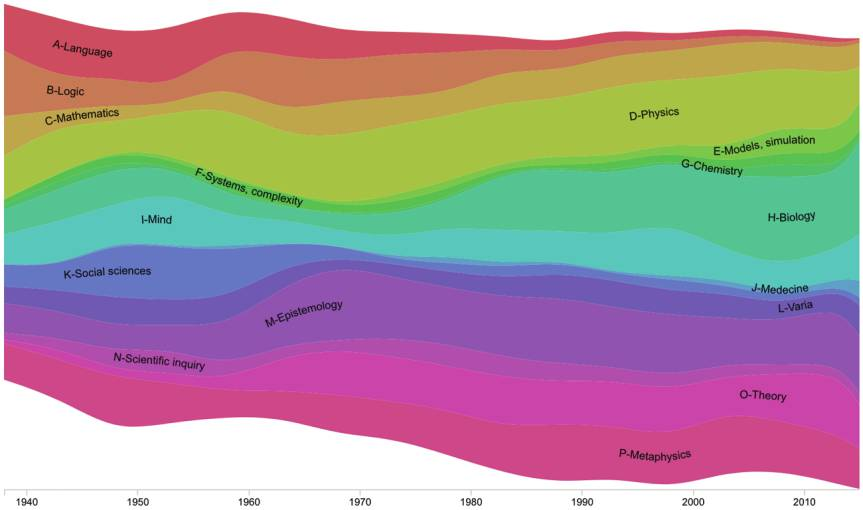

What we have here, thanks to the work of Christophe Malaterre and colleagues, is a topic model of eighty years of content in the journal _Philosophy of Science._ As it turns out, the "topics" – when we apply some subjective content knowledge and interpretation – really do pick out _topics_ that authors have been writing about in the journal over the last eighty years. We can confirm some hypotheses that we might have already had (say, that philosophy of language and logic were once very central to philosophy of science, but have since begun largely publishing in their own journals), and find others to investigate (for instance, there's some support here for the idea that the philosophy of biology was quite significant early on, rather than being "novel" in the 1970s and 1980s; a claim for which authors like Dan Nicholson have argued).

So, in short, that's why we do this: it turns out that when you let this unsupervised algorithm go on a collection of documents, the "topics" that result – the probability distributions of each word given each topic $\Pr(w \mid t)$ – really do seem to give us information about what the corpus is _about._

How do we extract that information from the topics? The most common way is simply to look at which words are the _most likely_ in each topic. As it turns out, these will usually be extremely suggestive, painting for us a picture of what that topic is "about." (Meaningless or generic words will likely be used equally everywhere, so they'll appear in every topic, with a low probability. Or, as we'll see below, they may be clustered into what are sometimes called "junk" or "jargon" topics that don't – or don't seem to – have any meaning.)

Here's an example from a paper on topic modeling in science:

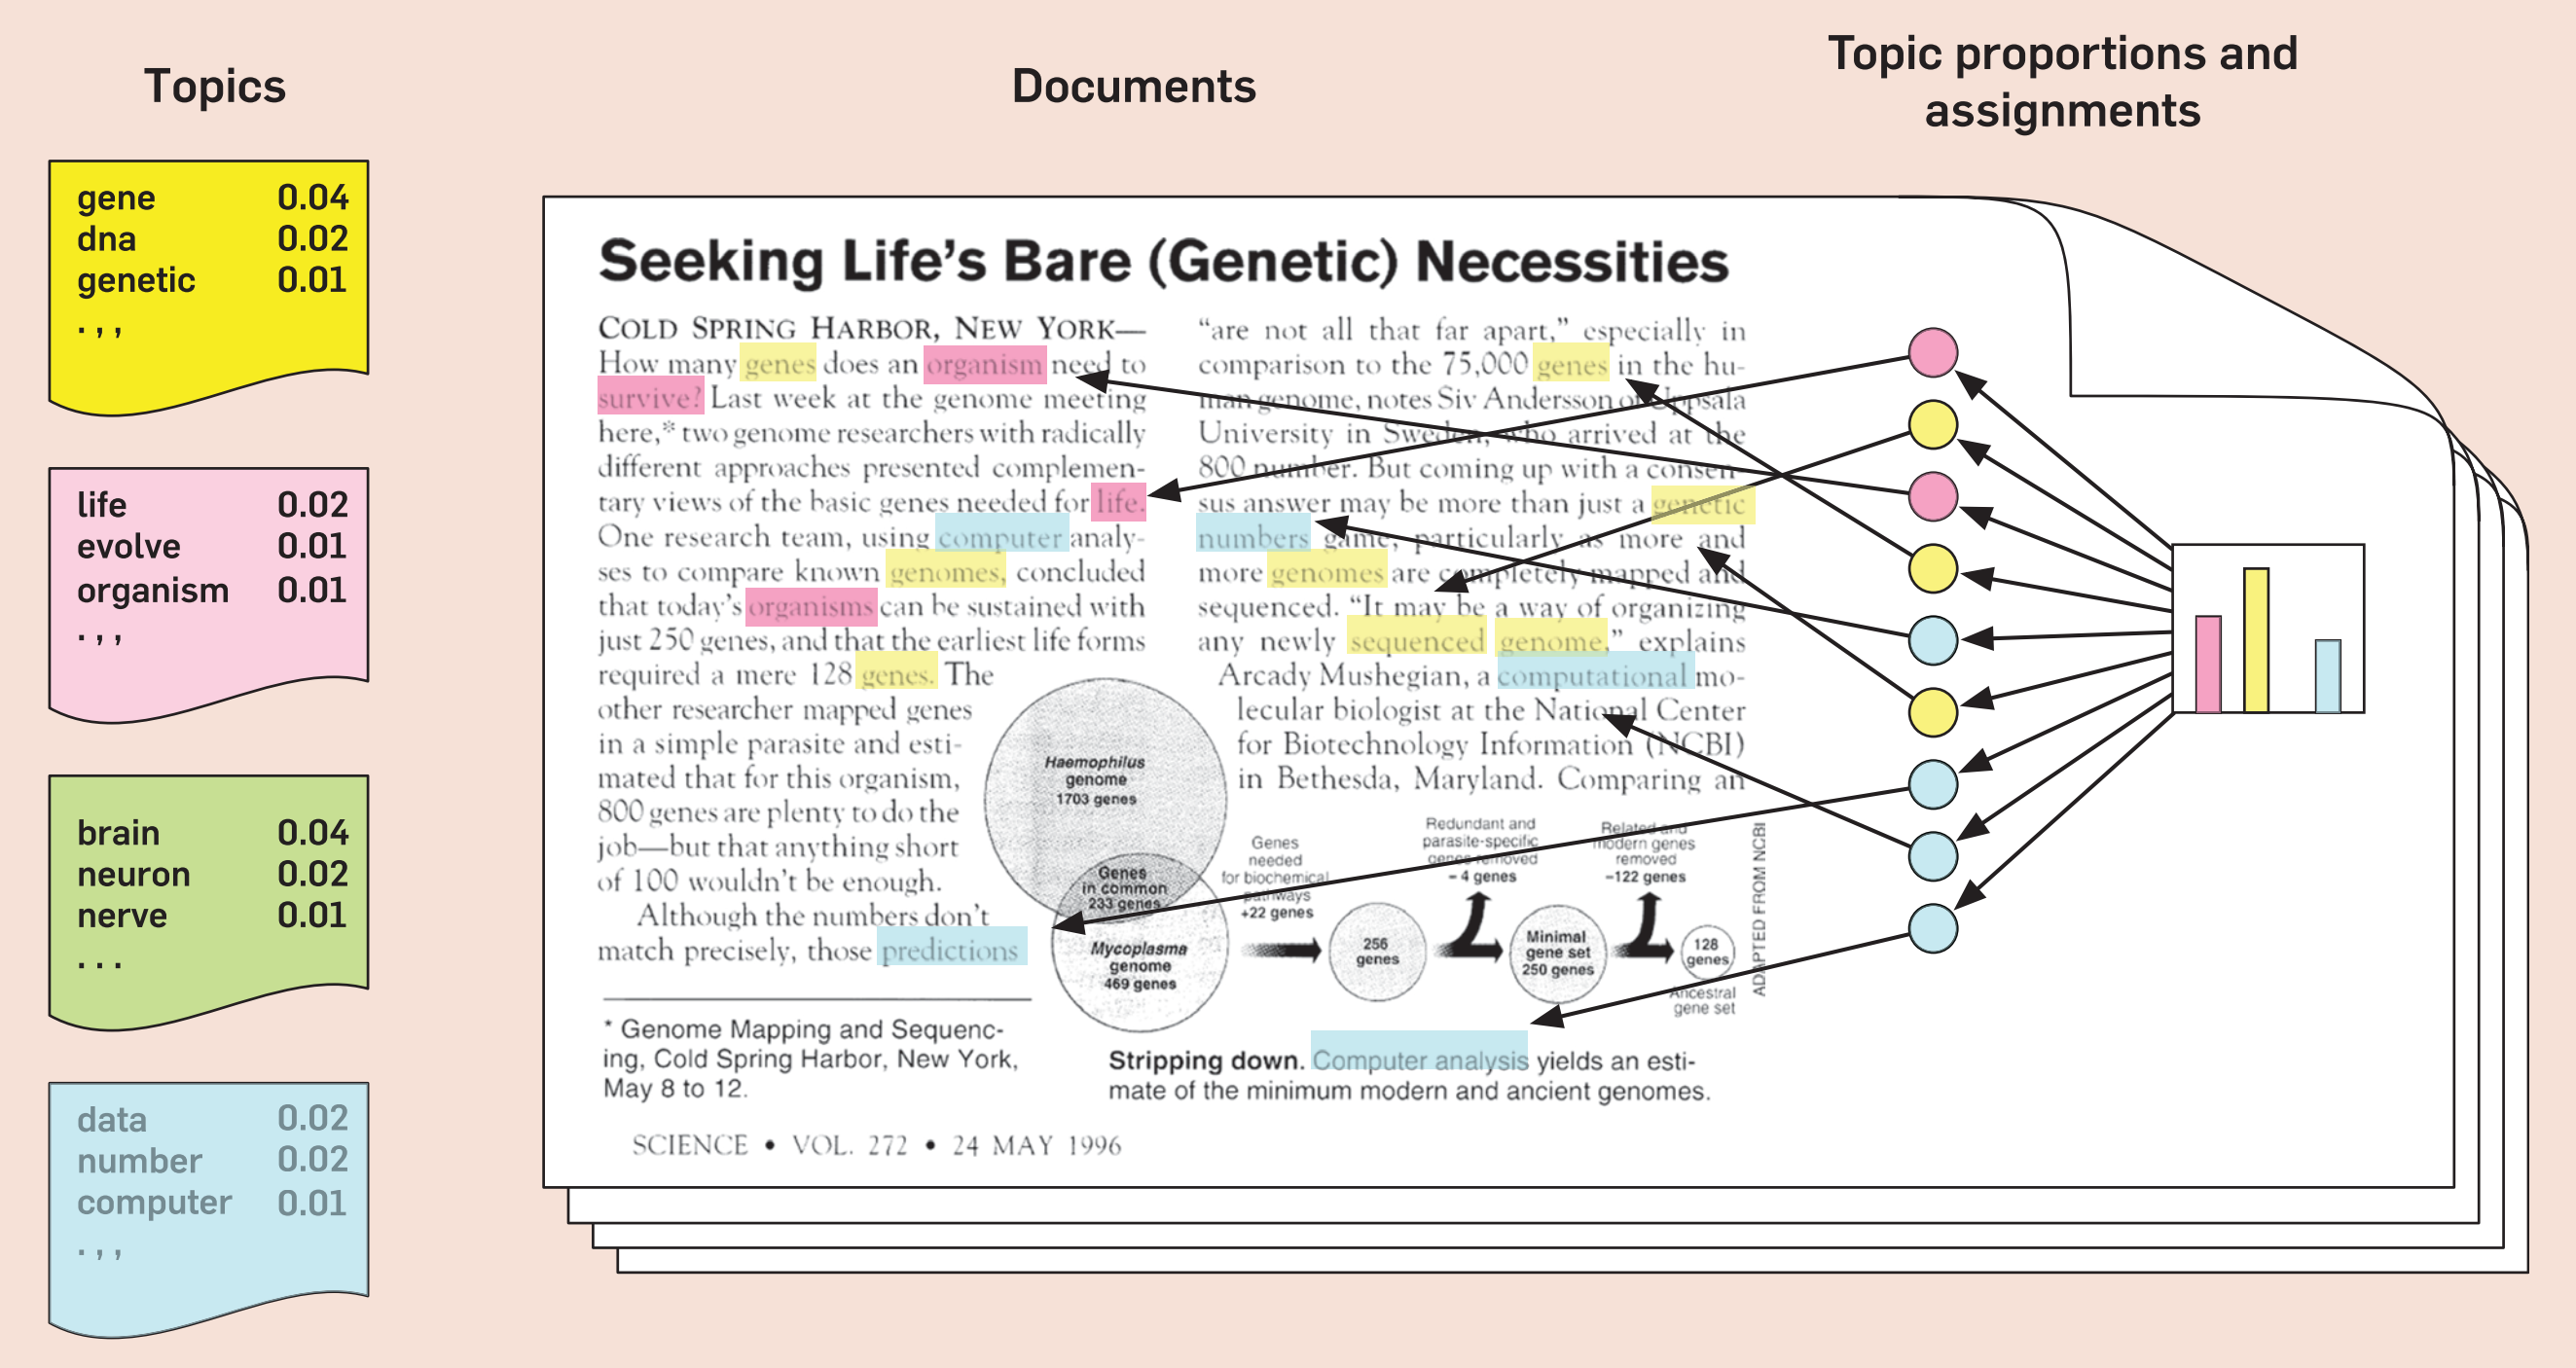

You can see that, if this were your topic model, you might think that the yellow topic is "about" genetics, the pink topic "about" evolutionary biology, and the green topic "about" neuroscience. Again, recall that the algorithm itself has _absolutely no idea_ what these documents are really about – all these topics have been derived in a fully automated way from the corpus.

# An Example

Enough talking, let's write some code! First, we need to install some packages. Our main topic modeling system is known as `gensim`:

In [ ]:
%pip install gensim

# gensim is currently printing out a huge number of deprecation warnings. It's
# bad practice to turn them off, but let's do it anyway.
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

And we also need to install the `spacy` package, which we'll use to clean up our corpus, along with the language model that it'll use to parse English text (more on that in a moment):

In [ ]:
%pip install spacy
%pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.3.0/en_core_web_lg-3.3.0-py3-none-any.whl#egg=en_core_web_lg

Note that you wouldn't want to use that model if you had non-English text. But spaCy has models available in all kinds of different languages; [check the page here to find the name of another model if you need it](https://spacy.io/models). Finally, we're going to install a visualization package that we'll use later on:

In [ ]:
%pip install pyldavis

We'll be using JSON as a metadata format below, so make sure it's available:

In [ ]:
import json

Lastly, let's set up logging, which we'll use to do some optimizations later on:

In [ ]:
import logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s",
                    level=logging.NOTSET)

# But start with logging turned off (we'll turn it on when we want it)
logging.disable(logging.CRITICAL)

This code just makes many of the `gensim` model construction functions print copious amounts of debugging information into this notebook when you run them, so that you can see what they're doing.

## Building a Corpus

Now, we need to get a corpus.

### From Text Files

For an example case built from text files, I'm going to use the abstracts from _PLoS Biology_, because that's small, and so it'll run quickly. The full-text corpus would give much better results, of course, but let's refine things step by step.

In [ ]:
# Get a list of filenames in the corpus
from pathlib import Path


With luck, that should have just told you that you have 4,781 abstracts downloaded. Not bad.

### From JSTOR Constellate

You can also get your text directly from JSTOR, using their [Constellate](https://constellate.org/) service. This is impressive, because it will give us a complete, full-text analysis capability on any collection of articles in JSTOR! To get started, go through their procedure for building a dataset – searching and refining until you get the collection of articles that you're interested in. You'll need to sign up for a JSTOR account in order to be able to save that dataset.

Once you click build and give your dataset a name, there will be a (possibly rather long) wait while the dataset is created.

We'll also need to install the Python package used for talking to the Constellate servers:

In [ ]:
%pip install constellate-client

#### Small Corpora

If your dataset has less than 15,000 documents, you can import it _directly_ into Colab here without having to do any extra work. If you go to [your dataset dashboard in Constellate](https://constellate.org/dataset/dashboard), you'll see your list of datasets. If you look at each dataset in the list, you'll see that they have an ID (a long hexadecimal string, more precisely, a UUID). Here's what I mean for one of JSTOR's sample datasets:

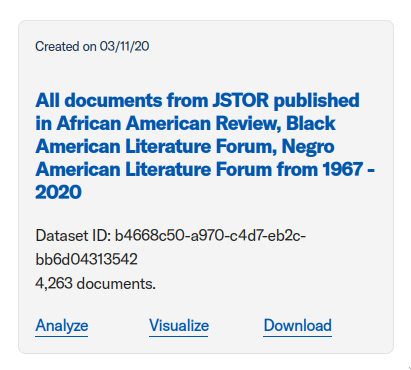

The dataset ID here is `b4668c50-a970-c4d7-eb2c-bb6d04313542`. To download this (relatively small) dataset directly, we can call the Constellate package:

In [ ]:
# Input your dataset ID here
dataset_id = "3b8042a8-a2fa-1945-3de7-fdb6a2b28eb3"

# Download the dataset
import constellate
dataset_file = constellate.get_dataset(dataset_id)

We now have a filename for the downloaded data. Skip down below the next section to ["Extracting JSTOR data".](#scrollTo=GoONZcGA4fUQ&line=3&uniqifier=1)

#### Large Corpora

If you have a very large corpus, you'll need to download the file yourself. To do that, click on the "Download" link that you see up above. That'll pop up a list of available downloads:

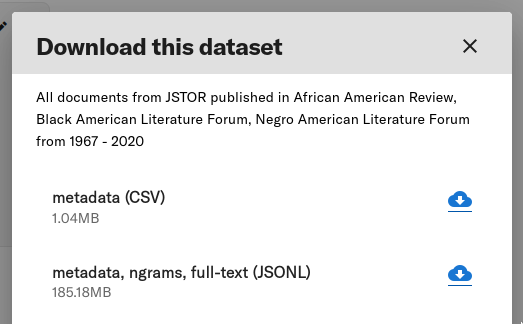

Download that second file – the metadata, ngrams, and full-text. (That's the same file that we would have gotten from the Constellate package above.)

Now, to get it into this notebook, we'll need to upload it to Google Drive. Go to [your Google Drive page,](https://drive.google.com/) and drag and drop the file into the Drive window, then wait for the upload to finish.

Next, generate a Google Drive sharing links for the file. Click on it, and click on the share icon above (the person with the plus sign). That will pop up a window. Go to the permissions at the bottom, which default to "Restricted", click the dropdown menu, and change them to "Anyone with the link". Then click "Copy link". That will give you a link that looks like `https://drive.google.com/file/d/(lots of characters)/view?usp=sharing`.

Finally, you can download the file by running:

In [ ]:
# Replace this URL with the one to your dataset file:
dataset_file_url = "https://drive.google.com/file/d/17nkgBbLPyBx_uYKABEt1-Dc7AyBOCmLC/view?usp=sharing"

# Download the file
!gdown --fuzzy {dataset_file_url} -O dataset.jsonl.gz

# Save that filename
dataset_file = "dataset.jsonl.gz"

#### Extracting JSTOR Data

We now need to turn that JSTOR file into something that we can use later.

First, let's parse the metadata. I'm going to turn it into the same format that I've used for the _PLoS Biology_ data, so that we can use the same parsing code in the rest of this notebook for both corpora:

In [ ]:
# We'll put the metadata here
metadata_folder = "topic-modeling-2022/data/jstor-json/"
!mkdir -p {metadata_folder}

# Walk through each document in the dataset
for idx, document in enumerate(constellate.dataset_reader(dataset_file)):
  metadata = {
      # These are the only two pieces of metadata that we use
      "title": document["title"],
      "date": document["publicationYear"]
  }

  # Write it out as a file
  with open(metadata_folder + str(idx) + ".json", "w") as f:
    json.dump(metadata, f)

Next, let's create a text-file document containing all the words from the text. This is _not_ the full text of the documents! It's just a list of all their words, in which each word appears as many times as it appears in the original document. For instance, "this is a test, only a test" would become "a a is only test test this". For our purposes, luckily, that's good enough!

In [ ]:
# These aren't really abstracts, but if I use this folder name, all the code
# below will work better.
document_output_folder = "topic-modeling-2022/data/jstor-abstracts/"
!mkdir -p {document_output_folder}

# Walk through each document in the dataset again
for idx, document in enumerate(constellate.dataset_reader(dataset_file)):
  # Get the list of "one-grams" -- every word and how many times it appears in
  # the document
  unigrams = document['unigramCount']

  # Build the list of terms
  ret = []
  for gram in unigrams.keys():
    ret += [gram] * unigrams[gram]

  # Write it out as a text file
  with open(document_output_folder + str(idx) + '.txt', 'w') as f:
    f.write(' '.join(ret))

Finally, let's tell the rest of our code where to find that JSTOR data:

In [ ]:
# Set some variables we were using above
corpus_directory = document_output_folder
corpus_filenames = list(Path(corpus_directory).glob('*.txt'))

print(f"...found {len(corpus_filenames)} abstracts!")

### Parsing the Corpus

Next, let's process these into a format that we can actually use.

In [ ]:
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk import WordPunctTokenizer
import re
from nltk.stem import WordNetLemmatizer
 
 
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
en_stop =set(stopwords.words('english'))
stemmer = WordNetLemmatizer()



 
# We'll put our results into corpus_tokens
corpus_tokens = []
 
# Import a nice progress bar so that you can watch how things are going
from tqdm import tqdm
 
for filename in tqdm(corpus_filenames):
  # Read the file's contents
  with open(filename) as f:
    document = f.read()
    
  document = re.sub(r'\W|\d', ' ', str(document))
 
  # remove all single characters
  document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
 
  # Remove single characters from the start
  document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)
 
  # Substituting multiple spaces with single space
  document = re.sub(r'\s+', ' ', document, flags=re.I)
 
  # Removing prefixed 'b'
  document = re.sub(r'^b\s+', '', document)
 
  # Converting to Lowercase
  document = document.lower()
 
  # Lemmatization
  tokens = document.split()
  tokens = [stemmer.lemmatize(word) for word in tokens]
  tokens = [word for word in tokens if word not in en_stop]
  ret = [word for word in tokens if len(word) > 3]
  
  # And add the whole set of tokens for this document
  corpus_tokens.append(ret)
 
# Count the frequencies of all those words
from collections import defaultdict
frequency = defaultdict(int)
 
for doc in tqdm(corpus_tokens):
  for token in doc:
    frequency[token] += 1
 
# Only keep words that appear more than MIN_OCCURRENCE times
MIN_OCCURRENCE = 2
corpus_tokens = [[token for token in doc if frequency[token] >= MIN_OCCURRENCE]
                 for doc in corpus_tokens]


Now, that's a serious piece of code, so let's talk through what it's doing.

First, as the comments say, we import spaCy, a natural language parsing system, and load up the big model that we downloaded earlier. That's going to allow us, most importantly, to tag the _part of speech_ for each word in the corpus, which we're going to use below to filter out some words we don't want. This processor is also very smart about things like punctuation, quotation marks, hyphens and dashes, and so forth.

We read the text of each file, and all of that linguistic parsing happens when we call `nlp(text)`. That function returns a set of token objects from spaCy. We now get to make our first serious set of design choices for our analysis: **what tokens do we want to throw away?**

If nothing else, you almost certainly want to discard stop words – a defined list of "filler words" like "a", "an", "the", and so forth – and it's a good idea to toss any tokens that are one or two letters, since those are almost always the result of some kind of text processing or scanning glitch.

Commented out (feel free to un-comment it, though!) is an example of another kind of test you might use. I have in the past run topic models on journals with *heavy* mathematical content. When you scan a table of numbers, or a formula, what you tend to get is *lots* of junk. One way to throw lots of that junk away is to ignore any token that has a number in it. Of course, that's going to be a huge problem if you *want* to analyze tokens with numbers in them! What kind of cleaning is best for your particular case is up to you.

Then, we actually put that language parsing to use: we keep only tokens that are nouns, verbs, adjectives, adverbs, proper nouns, and foreign words. Exactly which tags are used will depend on the model that you have loaded. (Since we've used `en_core_web_lg`, you can see the full documentation of part-of-speech tags [on this page, under "label scheme."](https://spacy.io/models/en#en_core_web_lg)) Topic modeling works best if we strip out words that aren't meaningful _by themselves_, like conjunctions, prepositions, and pronouns. As we'll see below, we're going to end up keeping _only_ the frequencies of each word within documents, and it's just not interesting (for our purposes) to know that one document uses "than" more than another one does.

Lastly, once we've decided that we're keeping a word, we add the *lemmatized* version of that word to the corpus. Lemmatization is a way to "standardize" the forms of words within a text. All plural nouns become singular, and all forms of a verb become the infinitive – so "words" would be come "word", and "going", "went", and "goes" would all becme "go". This is one small way in which we make it easier for the computer not to be confused by details of syntax.

Finally, we do one more bit of cleaning: we count up the frequency of every word in the corpus, and we throw away any words that appear less than `MIN_OCCURRENCE` times. Here, I've set that to 2 – so we're just throwing out all words that appear only once. That's probably always a good idea: a word that appears in only one document can't teach us much about what that document means, since we don't get information about the _pattern_ of association between it and other words. If your corpus is very large, you might set this variable _much_ higher, to keep rare terms from biasing the construction of topics.

> Random aside: I really love the `tqdm` function. As you see, you can wrap it around any loop that you want to run, and *poof* you'll get a pretty progress bar that lets you know your computer hasn't crashed, or whether you have time to run and get a coffee before the processing is finished.)

With that done, though, it's time to get those lists of tokens into the format that we'll actually use for creating the topic model:

In [ ]:
from gensim import corpora

# Create a dictionary
corpus_dict = corpora.Dictionary(corpus_tokens)

# Create a matrix-form corpus
corpus_matrix = [corpus_dict.doc2bow(doc) for doc in corpus_tokens]

# Write out all of our intermediate files, for safe-keeping
import pickle

with open("corpus_filenames.pickle", "wb") as f:
  pickle.dump(corpus_filenames, f)
with open("corpus_tokens.pickle", "wb") as f:
  pickle.dump(corpus_tokens, f)
corpus_dict.save("corpus_dict.dict")
corpora.MmCorpus.serialize("corpus_matrix.mm", corpus_matrix)

# Print some statistics, for the wow value
print("Corpus statistics:")
print(f" - number of documents: {len(corpus_filenames)}")
print(f" - number of tokens: {sum([len(doc) for doc in corpus_tokens])}")
print(f" - number of types: {len(corpus_dict)}")

Notably, the end of this code writes out all of your data files for safe-keeping (especially useful if you want to work with multiple corpora and back them up!). If you want to *load* your corpus from the files that are saved, you can run the next block (otherwise, no need):

In [ ]:
with open("corpus_filenames.pickle", "rb") as f:
  corpus_filenames = pickle.load(f)
with open("corpus_tokens.pickle", "rb") as f:
  corpus_tokens = pickle.load(f)
corpus_dict = corpora.Dictionary.load("corpus_dict.dict")
corpus_matrix = corpora.MmCorpus("corpus_matrix.mm")

What did that last step actually create?

We first created a dictionary object, which is essentially a mapping between every word type (that is, every unique word), and numbers. To put it simply, each word in the corpus gets an ID number.

Then, we turn the whole corpus into a giant numerical representation. Essentially, this is a big matrix, although internally it's not stored that way. The trouble is that since most documents don't include most words, the matrix representation of the corpus would be _extremely_ sparse (almost all of its entries would be zero). That makes for very inefficient storage, if we're not careful. What we do to get around that is store each document as an object like this:

```python
[(word, freq), (word, freq), ...]
```

If you inspect the `corpus_matrix` object, you'll see something like:

```python
[[(0, 1.0),
 (1, 1.0),
 (2, 1.0),
 (3, 1.0),
 (4, 1.0),
 (5, 1.0),
 (6, 1.0),
 (7, 1.0),
 (8, 1.0),
 (9, 1.0),
 (10, 4.0),
 (11, 2.0),
 (12, 1.0),
 (13, 5.0),
 (14, 3.0),
 ...
], ...]
```

What this says, then, is that the first document has 1 instance of word 0, 1 instance of word 1, ..., 4 instances of word 10, 2 instances of word 11, ..., and the same for every other document in the corpus. We've turned the text into a matrix of frequencies of words within documents.

## Training a Model

That's the kind of thing that we can feed to an algorithm. So let's train our first topic model!

In [ ]:
# Some configurable parameters -- we'll come back to these later
PASSES = 10
ITERATIONS = 300

# Calculate a chunk size -- just make it big enough to hold the whole corpus.
# If you have a limited amount of RAM, you can reduce this value and the
# documents will be added to the model in batches.
corpus_size = len(corpus_filenames)
chunk_size = round(corpus_size, -3) + 1000

# Turn on logging, so that you can see something happening while this runs.
logging.disable(logging.NOTSET)

# Train a first model!
from gensim.models.ldamodel import LdaModel

first_model = LdaModel(
    corpus=corpus_matrix,
    id2word=corpus_dict,
    num_topics=10,
    chunksize=chunk_size,
    iterations=ITERATIONS,
    passes=PASSES,
    alpha="auto",
    eta="auto",
    random_state=1337
)

# Turn logging back off again for later
logging.disable(logging.CRITICAL)

There are a _lot_ of configurable parameters here, so before we look at the output of that model, let's look at the input.

The `PASSES` and `ITERATIONS` values are something that you can configure yourself – I'll come back to discussion of those in a bit [when I talk about refining this initial model.](#scrollTo=XbwmWXHHhU_e) (Very briefly, they're how we make sure that the model actually computes long enough to converge to a good solution.)

The `num_topics` variable is the big one, where we set how many topics we're going to infer. As I noted above, that's chosen freely by the user. We'll talk some [down below](#scrollTo=mY-mr3Z9qpZ1&line=1&uniqifier=1) about how the computer can help us choose that value.

The `chunk_size` value is there to help for some kinds of memory and CPU optimization. Processing the whole corpus at once, as we do here, is simplest but has the highest requirements; setting this to a lower value could help for an enormous corpus or a low-memory environment.

The `alpha` and `eta` parameters configure how the priors for the algorithm will be set. `alpha` describes the priors for the document-topic distributions, and `eta` the priors for the topic-word distributions. In essence, the default (and slightly faster) value is `"symmetric"`, which assumes a symmetric and evenly distributed prior over all topics/words. Replacing that with `"auto"` as I've done here activates code that attempts to guess an asymmetric prior from the corpus. Again, that's slower, but in my experience it gives better results. You might think about changing it if you're getting very strange topic models, or if your models are failing to converge (see below concerning `PASSES` and `ITERATIONS`).

Lastly, `random_state` fixes the seed for our random number generator, so that every time we run the model we'll get the same results. (That's extra-helpful in a Python notebook, so there's no issues if you run a code block more than once.)

## Visualizing Our Results

How do we look at what we've got? First and foremost, we can take a quick glance at the top words from all of the topics with the following snippet of code:

In [ ]:
top_words = first_model.show_topics(num_topics=25, num_words=10, formatted=False)
for topic in top_words:
  print("")
  print(f"TOPIC {topic[0]}")
  print("----------")

  for word in topic[1]:
     print(f" - {word[0]} ({word[1]})")

This is probably already enough for you to get some idea about what topics are present in the corpus! For some fancier visualization, let's try this:

In [ ]:
# Build a visualization
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
vis = gensimvis.prepare(first_model, corpus_matrix, corpus_dict)
pyLDAvis.display(vis)

Now we're talking! This visualization shows us all kinds of interesting stuff. On the left, you have a (obviously simplified to two dimensions) visualization of the "separation" between topics – as you can already probably tell from the "top words" above, some topics are intuitively "more similar" than others, and this is an effort to show that. The size of nodes gives you an idea of how "common" each topic is in the corpus as a whole. You can then work through the topics in the corpus, seeing which words are most important for the topic, as well as whether each one is a word that's overall very common, and an estimate of "how much" of the word is due to each topic. (Again, recall the document-creation model: this is roughly how many of the instances of the word are in the corpus because _this_ was the topic that we picked that led to that word being chosen.)

# Refining Our Process

So, we can build one topic model, with one number of topics, and we can visualize what its results look like. That's great! But now we want to refine our process. First, how do we know how to tune the parameters of that model so that we're getting good results?

## Testing Model Convergence

> *Advanced topic: if you're interested in making very sure you have your optional parameters tuned correctly.*

The default settings above should work well in lots of cases. But if you want to be super-careful, here's how you can make sure that you have `PASSES` and `ITERATIONS` set correctly.

First, a bit more about what these variables describe (taken largely from [here](https://www.meganstodel.com/posts/callbacks/)). `PASSES` controls how many times the algorithm will run _over the entire corpus_ – essentially re-training on the same documents. The default in `gensim` for this value is `1`. That might sometimes be enough, but a higher value can help; I've used values as high as `20`. `ITERATIONS` is the maximum number of iterations that the algorithm will try before it gives up, if it hasn't yet converged on a solution. Setting a very high value for this parameter, as I have here, means that the algorithm will try _very_ hard to get your solution to converge. You almost never want to take this value _higher_ than `300`, though you can go lower; the `gensim` default is only `50`.

How can you tell whether you should make `PASSES` higher? Look at the output in the logs for the first model training up above.

First of all, if you see a line like:

```
WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
```

then the algorithm itself has already decided that you probably have `PASSES` too low.

If you don't see that, look for output like the following:

```
2022-07-09 15:19:40,476 : INFO : PROGRESS: pass 0, at document #4781/4781
2022-07-09 15:19:40,478 : DEBUG : performing inference on a chunk of 4781 documents
2022-07-09 15:19:51,926 : DEBUG : 3665/4781 documents converged within 300 iterations
[...]
2022-07-09 15:20:21,083 : INFO : PROGRESS: pass 4, at document #4781/4781
2022-07-09 15:20:21,085 : DEBUG : performing inference on a chunk of 4781 documents
2022-07-09 15:20:23,961 : DEBUG : 4781/4781 documents converged within 300 iterations
```

You can see here that after the first pass (pass 0), 3,665 of the 4,781 documents had "converged" – that is, the solver was able to find a "good" topic distribution for around 77% of the documents. By pass 4, we had good solutions for every single one. So you could probably get away with around 4 passes in this dataset. (I always round up a bit, so here I'd do 5 or 10.) As a rule, adding _more_ passes doesn't harm anything but time and electricity.

## Optimizing Number of Topics

As I've already mentioned, there's a huge, free user choice that needs to be made before you start training a topic model: _the number of topics._ It'd be nice to have some kind of guide concerning that number, right? How do we know that we've picked it well?

On the one hand, part of this will always be finesse and subjectivity. In addition to objective measures like those we're about to look at, there are also pragmatic concerns that govern how many topics we want to use. Perhaps you only _want_ a very rough categorization of your corpus? Then you should use fewer topics. Perhaps you want to make sure that you can do careful, human-guided confirmation of what each topic "means," reading some articles from each topic (we'll talk about how to do that below). Then you want a small number of topics. Perhaps you want to find really fine-grained features of your corpus, and you're going to use automated methods to look at the _pattern_ of topic usage rather than privileging detailed investigation of any specific topic? (That's a kind of analysis that's beyond our scope in this notebook, but it's still worth mentioning!) Then you probably want _lots_ of topics. All those are, in the end, subjective decisions about your research goals.

But on the other hand, there are some ways that we can get metrics that will help. Let's look at how to evaluate what we'll call the *coherence* of a set of topic models (for more information, [see this paper](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf)).

To start, we're going to want to train a bunch of models, so we should make that model-generation code from up above into a reusable function:

In [ ]:
def model_for(num_topics):
  return LdaModel(
      corpus=corpus_matrix,
      id2word=corpus_dict,
      num_topics=num_topics,
      chunksize=chunk_size,
      update_every=1,
      iterations=ITERATIONS,
      passes=PASSES,
      alpha="auto",
      eta="auto",
      random_state=1337
  )

Now, we should train up a bunch of models to compare (**NB!** This takes around 40 minutes to execute, perhaps a bit more):

In [ ]:
NUM_TOPICS = [2, 3, 4, 5, 6,
              7, 8, 9]

models = {}
for n in tqdm(NUM_TOPICS):
  models[n] = model_for(n)

Next, we build a coherence model – a way of measuring the quality of each model to see which might be the best:

In [ ]:
# Create a coherence model
from gensim.models.coherencemodel import CoherenceModel
cm = CoherenceModel.for_models(
    models.values(),
    corpus_dict,
    corpus=corpus_matrix,
    texts=corpus_tokens,
    coherence="c_v"
)
coherence_estimates = cm.compare_models(models.values())
coherences = dict(zip(models.keys(), coherence_estimates))

coherence_list = [(num_topics, avg_coherence)
  for num_topics, (_, avg_coherence) in coherences.items()]
ordered = sorted(coherence_list, key=lambda tup: tup[1], reverse=True)

print(f"Ranked by average '{cm.coherence}' coherence:\n")
for item in ordered:
  print("num_topics=%d:\t%.4f" % item)
print(f"\nBest: {ordered[0][0]}")

Before we get into interpreting these results, let's start with the basic idea. Coherence measures are intended to show the extent to which a topic model is "supported" by the corpus. The idea is roughly that words that are considered to be important within each topic should "travel together" in the documents – they should be used within a reasonable distance of each other. This helps to capture the sense in which topics gather together words that are "about" the same thing ([you can find a nice, more detailed write-up of these ideas here](https://towardsdatascience.com/understanding-topic-coherence-measures-4aa41339634c)).

When I first ran this analysis, I got the following results:

```
Ranked by average 'c_v' coherence:

num_topics=16:	0.4982
num_topics=14:	0.4936
num_topics=4:	0.4919
...
num_topics=125:	0.4183
num_topics=100:	0.4116
num_topics=150:	0.3943

Best: 16
```

So, as you can see, the 16-topic model comes out on top according to this metric. Very large models do _substantially_ worse.

Let's graph the results to look at them more clearly:

In [ ]:
# Enable graphing in the notebook
import matplotlib.pyplot as plt
%matplotlib inline

# Graph coherences
x_coords = [num_topics for num_topics, _ in coherences.items()]
y_coords = [c for _, (_, c) in coherences.items()]

plt.plot(x_coords, y_coords)
plt.xlabel("number of topics")
plt.ylabel("coherence")
plt.show()

As a rule, coherence graphs show a classic "elbow" shape. Very low numbers of topics will have low coherence, as the topics are forced to cluster together ideas that don't "travel together" in the corpus. Very high numbers of topics will also have low coherence, as the algorithm has been asked to make too many distinctions, and thus starts grasping for distinctions without a difference. The peak, right at the "elbow" of the graph, is usually a small-but-not-too-small number of topics. For instance, when I ran this dataset for the first time, the 16-topic model was actually the best. That graph looked like this (yours might vary):

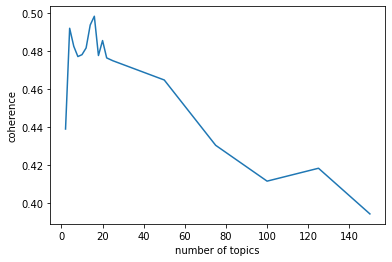

Of course, as I've already noted, you have to balance pragmatic with objective concerns here. The 16-topic model was great, but the 4-topic model was only a _little_ bit less good – so perhaps you'd have good, independent reasons for choosing that one!

But you now have a tool that lets you better understand whether a particular topic model is good or not. There is no substitute for human judgment here: no value of coherence is magically "good enough" to make a topic model interesting, or for it to say important things about your corpus. (In fact, you should try to avoid interpreting the numerical values for coherences in anything but a comparative fashion.) But it's an invaluable aid in thinking about which model you'd like to analyze in depth.

## Summing Up

Since we're happy with our values of `ITERATIONS` and `PASSES`, and we think the 16-topic model is the peak of our coherence graph, let's generate our "final" model:

In [ ]:
final_model = model_for(16)
final_model_topics = 16

# Asking Questions

Now that we have this fancy model, we want to be able to ask it questions: what can it tell us about our corpus?

## Top Words

The first step here is assuredly to run the snippet of code from above that prints out the top words for each topic in the corpus, which will let us start to interpret the topics.

In [ ]:
top_words = final_model.show_topics(num_topics=final_model_topics,
                                    num_words=10,
                                    formatted=False)
for topic in top_words:
  print("")
  print(f"TOPIC {topic[0]}")
  print("----------")

  for word in topic[1]:
     print(f" - {word[0]} ({word[1]})")

At least when I ran this analysis for the first time, I got the following result (formatted nicely and annotated with my own gloss on each topic):

| Topic | Words | Interpretation |
| ---- | ---- | ---- |
| 0 | study, neuron, mouse, human, disease | mouse neural models |
| 1 | specie, human, datum, evolution, population | human genetics |
| 2 | cell, tissue, gene, mechanism, tumor | cancer biology |
| 3 | protein, cell, dna, gene, rna | genetics |
| 4 | activity, neuron, cortex, cortical, brain | neuroscience |
| 5 | cell, signal, membrane, protein, model | cell signaling |
| 6 | stimulus, neural, sensory, response, brain | perception |
| 7 | cell, receptor, bind, protein, domain | protein biology |
| 8 | actin, activity, mechanism, study, sleep (9th) | generic? |
| 9 | research, science, scientific, biology, scientist | junk topic |
| 10 | cell, protein, signal, clock, circadian (10th) | circadian biology |
| 11 | protein, cell, age, mouse, lipid | generic? |
| 12 | gene, cell, protein, expression, function | molecular biology and genetics |
| 13 | cell, gene, expression, protein, signal, development | developmental biology |
| 14 | host, gene, population, genetic, evolution, model | immunology, parasitology |
| 15 | datum, sleep, research, study, animal | generic? |

An interesting case is topic 8, where we have lots of generic scientific terms, but also "actin" as the first term and "sleep" as the 9th. That topic is hard to interpret.

Topic 11 presents similar problems. We have a lot of molecular biology terms, but also "lipid" and "species," both of which are a little unusual in that context.

You can also see a "junk" topic in topic 9. As you see there, all these are terms that we would expect to appear in _any_ article in _PLoS Biology_ – they don't pick out anything distinctive at all. The more topics you have, the more likely it is that you'll sometimes see topics like this.

An initial response to this collection of topics might be that we have actually chosen too many! It seems like basic molecular/protein terms have been spread across lots of different topics. But let's pretend as though we had good reasons to try to understand these topics (especially the hard ones, like 8, 11, and 15), and see how we might do so.

## Top Documents

One nice way to see what's going on in unusual topics is to see which documents drew the most from those topics. Here's a snippet of code to do just that:

In [ ]:
# For each topic,
for topic in range(final_model_topics):
  # Find the probability of that topic in each document
  probs = [(ind, item[1]) for ind, doc in enumerate(corpus_matrix) for item in final_model.get_document_topics(doc) if item[0] == topic]

  # Sort the list
  probs = list(probs)
  ordered = sorted(probs, key=lambda it: it[1], reverse=True)
  
  # Print the top ten document filenames
  print("")
  print(f"TOPIC {topic}")
  print("----------")
  for i in range(10):
    print(f"{ordered[i][1]}: {corpus_filenames[ordered[i][0]]}")

To really be able to look over these results quickly, though, it'd be nice to be able to go right to a list of titles. For that, we need access to the metadata of each article. That'll be different for every data-source and every journal. I happen to have added metadata for these articles in the format we use over at [Sciveyor](https://www.sciveyor.com) to the git repository that we cloned earlier (or, if you're using JSTOR data, we created those files ourselves), so I'll use that:

In [ ]:
# Load JSON files for metadata
corpus_json = []

for filename in corpus_filenames:
  json_filename = str(filename).replace("_abstract", "").replace(".txt", ".json").replace("-abstracts/", "-json/")
  
  with open(json_filename) as f:
    data = json.load(f)
  corpus_json.append(data)

Now we can repeat the same process as before, but print article titles instead of filenames:

In [ ]:
# For each topic,
for topic in range(final_model_topics):
  # Find the probability of that topic in each document
  probs = [(ind, item[1]) for ind, doc in enumerate(corpus_matrix) for item in final_model.get_document_topics(doc) if item[0] == topic]

  # Sort the list
  probs = list(probs)
  ordered = sorted(probs, key=lambda it: it[1], reverse=True)
  
  # Print the top ten document titles
  print("")
  print(f"TOPIC {topic}")
  print("----------")
  for i in range(10):
    print(f"{ordered[i][1]}: {corpus_json[ordered[i][0]]['title']}")

Now, remember that we were trying to understand topics 8, 11, and 15. Here's their most common documents:

**TOPIC 8:**
* Mice learn to avoid regret
* APOE Stabilization by Exercise Prevents Aging Neurovascular Dysfunction and Complement Induction
* Preservation of myocardial contractility during acute hypoxia with OMX-CV, a novel oxygen delivery biotherapeutic
* The neural system of metacognition accompanying decision-making in the prefrontal cortex
* A Rigidifying Salt-Bridge Favors the Activity of Thermophilic Enzyme at High Temperatures at the Expense of Low-Temperature Activity
* Neurocognitive processing efficiency for discriminating human non-alarm rather than alarm scream calls
* A KATP Channel-Dependent Pathway within α Cells Regulates Glucagon Release from Both Rodent and Human Islets of Langerhans
* The rostromedial tegmental nucleus is essential for non-rapid eye movement sleep
* Ryanodine Receptor Activation Induces Long-Term Plasticity of Spine Calcium Dynamics
* Activation of Arp2/3 Complex: Addition of the First Subunit of the New Filament by a WASP Protein Triggers Rapid ATP Hydrolysis on Arp2

**TOPIC 11:**
* A FRET-Based DNA Biosensor Tracks OmpR-Dependent Acidification of Salmonella during Macrophage Infection
* Echolocating Bats Use a Nearly Time-Optimal Strategy to Intercept Prey
* Variation in actuarial senescence does not reflect life span variation across mammals
* Induction of Biogenic Magnetization and Redox Control by a Component of the Target of Rapamycin Complex 1 Signaling Pathway
* Proteome-wide analysis of chaperone-mediated autophagy targeting motifs
* A novel nonosteocytic regulatory mechanism of bone modeling
* PGC-1α Deficiency Causes Multi-System Energy Metabolic Derangements: Muscle Dysfunction, Abnormal Weight Control and Hepatic Steatosis
* Fasting regulates EGR1 and protects from glucose- and dexamethasone-dependent sensitization to chemotherapy
* Lrrk promotes tau neurotoxicity through dysregulation of actin and mitochondrial dynamics
* A Helical Structural Nucleus Is the Primary Elongating Unit of Insulin Amyloid Fibrils

**TOPIC 15:**
* Partial homologies between sleep states in lizards, mammals, and birds suggest a complex evolution of sleep states in amniotes
* Sugar industry sponsorship of germ-free rodent studies linking sucrose to hyperlipidemia and cancer: An historical analysis of internal documents
* Isometric Scaling in Developing Long Bones Is Achieved by an Optimal Epiphyseal Growth Balance
* Multiple Citation Indicators and Their Composite across Scientific Disciplines
* Creating clear and informative image-based figures for scientific publications
* Thinking small: Next-generation sensor networks close the size gap in vertebrate biologging
* Assessment of transparency indicators across the biomedical literature: How open is open?
* Applying the science of measurement to biology: Why bother?
* Nesting box imager: Contact-free, real-time measurement of activity, surface body temperature, and respiratory rate applied to hibernating mouse models
* The Sharing Experimental Animal Resources, Coordinating Holdings (SEARCH) Framework: Encouraging Reduction, Replacement, and Refinement in Animal Research

Now, these still look _very_ hard to interpret. We see as we look at topic 15 that there's a bit of a "meta-science" bent here that might not have been as visible from the top-word list. 8 and 11, though, seem to have very little in common. It looks even more likely that we have too many topics here.

## Exploring Words

What if we want to go the other direction, and look at some particular word or concept of interest? First, we'd want to find all forms of that word in the corpus. We can do that with code like the following:

In [ ]:
# What are we looking for?
word_search = "specific"

# Find it in the dictionary
hits = []

for word_id, word in corpus_dict.items():
  if word.lower().find(word_search) != -1:
    hits.append((word, corpus_dict.dfs[word_id]))

hits.sort(key=lambda a: -a[1])
for (word, df) in hits:
  print(f"{word} [{df}]")

This will print out every word that actually appears in the corpus that contains the search string in `word_search`. So here, you get "specific" as well as "specificity," "conspecific," and so on. This is helpful to figure out what terms were present in our corpus and how they looked after our cleaning steps.

Now, say that we wanted to find which topics were important for 'specificity', since that's a reasonably common word:

In [ ]:
# Convert the word to an ID
word = 'specificity'
word_id = corpus_dict.token2id[word]

# Get its topics
word_topics = final_model.get_term_topics(word_id, 0.0)
word_topics.sort(key=lambda a: -a[1])

for topic, prob in word_topics:
  print(f"  topic {topic}: {prob}")

This will print out the probability of drawing that word from every topic in the corpus, in order from most probable to least probable. In the case of this word in particular, it looks like topics 7 and 4 are particularly important for us to study this concept. Neuroscience and protein biology – that sounds right!

## Exploring Time

Last but not least, what if we're interested in the same kind of graph that we saw from Malaterre's group above, where we explore the development of these topics over time? Sure! We can do that. We need to break the documents up by year (again, we'll need the metadata), and then sum the total topic density for each document published in that year.

In [ ]:
from dateutil.parser import isoparse

# Split the documents by year
docs_by_year = {}

for i, doc in enumerate(corpus_json):
  # It's possible that a document has no date; skip those
  if not doc["date"]:
    continue

  # Parse the date value
  d = isoparse(doc["date"])
  if not d.year in docs_by_year:
    docs_by_year[d.year] = []
  docs_by_year[d.year].append(i)

# Sum up the topic mass in each year, by topic
topic_mass_by_year = {}

for year, docs in docs_by_year.items():
  topic_mass_by_year[year] = [0] * final_model_topics

  for doc in docs:
    topics = final_model.get_document_topics(corpus_matrix[doc])
    for (topic, prob) in topics:
      topic_mass_by_year[year][topic] += prob

# Normalize so that each year sums to 1.0
# This step is optional: if you leave it out, the graph will also indicate which
# years contained more or fewer documents.
# for year, masses in topic_mass_by_year.items():
#   s = sum(masses)
#   topic_mass_by_year[year] = [x / s for x in masses]

# Build X and Y arrays for matplotlib
time_graph_x = []
time_graph_y = []
for i in range(final_model_topics):
  time_graph_y.append([])

for year, masses in sorted(topic_mass_by_year.items()):
  time_graph_x.append(year)
  for i, x in enumerate(masses):
    time_graph_y[i].append(x)

# If you want a centered flow graph, you probably want baseline="sym"; if you
# used the normalization above, you probably want baseline="zero"
plt.stackplot(time_graph_x, time_graph_y, baseline="sym")
plt.show()

Again, when I first ran this code, I got something like the following:

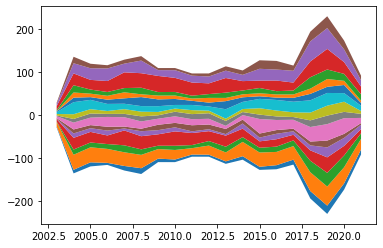

All in all, not very enlightening in this case, except to learn that there were a lot more documents published in 2018 and 2019 than in earlier years of the journal! It doesn't seem like there are particular trends in this data as regards topic. That's not surprising – _PLoS Biology_ is a new journal, and it's published basically the same kinds of papers since its inception.

> Aside: I noticed while playing with some of the larger topic models that models of this corpus with more topics will often produce a topic for SARS-CoV-2 – _that_ topic will surely show (perhaps very interesting) change over time!

# Summing Up

That was a lot, and there's still a lot more to do – I hope you can see that we've really just scratched the surface of what these methods can be used for! Going from here to real, publishable results requires a lot more time, effort, and – most importantly – a carefully formulated research question and real attention to the human interpretation that lies behind the data. There's nothing left now but to get to work!